import necessary packages into workspace

In [3]:
import numpy as np
from pprint import pprint

# for how to install tritonclient, refer to https://github.com/triton-inference-server/client
import tritonclient.http as httpclient

* start tritonserver with [example model](https://github.com/aws/amazon-sagemaker-examples/tree/main/sagemaker-triton/resnet50/workspace)

```bash
# docker images
REPOSITORY                    TAG         IMAGE ID       CREATED        SIZE
nvcr.io/nvidia/pytorch        24.01-py3   8470a68886ff   6 months ago   22GB
nvcr.io/nvidia/tritonserver   24.01-py3   4f00c79d1c09   6 months ago   14.7GB

# docker run --gpus all -t -d --rm --ipc=host --network=host --ulimit memlock=-1 --ulimit stack=67108864 -v /home/cuiyongbo/tensorflow-workspace/data-store/huggingface-store:/model-store nvcr.io/nvidia/tritonserver:24.01-py3

# docker container list
CONTAINER ID   IMAGE                                   COMMAND                  CREATED          STATUS          PORTS     NAMES
0269f37660a5   nvcr.io/nvidia/tritonserver:24.01-py3   "/opt/nvidia/nvidia_…"   12 seconds ago   Up 11 seconds             quirky_heyrovsky

# docker exec -u root -it 775a5a810f15 bash

# model hierarchy:
# tree /model-store/amazon-sagemaker-examples/sagemaker-triton/resnet50/triton-serve-pt
/model-store/amazon-sagemaker-examples/sagemaker-triton/resnet50/triton-serve-pt
└── resnet
    ├── 1
    │   └── model.pt
    └── config.pbtxt

2 directories, 2 files

# tritonserver --model-store=/model-store/amazon-sagemaker-examples/sagemaker-triton/resnet50/triton-serve-pt --allow-metrics=false --allow-grpc=false --model-control-mode=explicit --load-model=resnet
```

In [4]:
url = "localhost:8000" # tritonserver's address
verbose = True
triton_client = httpclient.InferenceServerClient(
    url=url, verbose=verbose
)

In [48]:
import numpy as np
from PIL import Image

In [49]:
image_path = "/home/cherry/Downloads/shiba_inu_dog.jpg"
img = Image.open(image_path).convert("RGB")

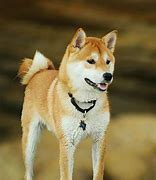

img.size: (156, 180)


In [50]:
display(img)
print("img.size:", img.size)

In [51]:
img = img.resize((224, 224))
img = (np.array(img).astype(np.float32) / 255) - np.array(
    [0.485, 0.456, 0.406], dtype=np.float32
).reshape(1, 1, 3)
print(img.shape)
img = img / np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape(1, 1, 3)
print(img.shape)
img = np.transpose(img, (2, 0, 1))
print(img.shape)
img = np.expand_dims(img, axis=0)
print(img.shape)


(224, 224, 3)
(224, 224, 3)
(3, 224, 224)
(1, 3, 224, 224)


In [53]:
from tritonclient.utils import np_to_triton_dtype, triton_to_np_dtype
from tritonclient.utils import InferenceServerException

model_name = "resnet"
inputs = [
    httpclient.InferInput("input", img.shape, np_to_triton_dtype(img.dtype)).set_data_from_numpy(img)
]
outputs = [
    #httpclient.InferRequestedOutput("output")
    httpclient.InferRequestedOutput("output", binary_data=True, class_count=1)
]

results = triton_client.infer(model_name=model_name, inputs=inputs, outputs=outputs)

POST /v2/models/resnet/infer, headers {'Inference-Header-Content-Length': 193}
b'{"inputs":[{"name":"input","shape":[1,3,224,224],"datatype":"FP32","parameters":{"binary_data_size":602112}}],"outputs":[{"name":"output","parameters":{"classification":1,"binary_data":true}}]}m\xaf\xa3\xbfm\xaf\xa3\xbfm\xaf\xa3\xbf\x92\xe0\xa5\xbf\x92\xe0\xa5\xbf\x92\xe0\xa5\xbf\xb7\x11\xa8\xbf\xb7\x11\xa8\xbf\xb7\x11\xa8\xbf\xdcB\xaa\xbf\xdcB\xaa\xbf\xb7\x11\xa8\xbf\x92\xe0\xa5\xbf\x92\xe0\xa5\xbf\x92\xe0\xa5\xbf\x92\xe0\xa5\xbf\x92\xe0\xa5\xbf\x92\xe0\xa5\xbf\x92\xe0\xa5\xbf\x92\xe0\xa5\xbf\x92\xe0\xa5\xbf\x92\xe0\xa5\xbf\x92\xe0\xa5\xbf\xff\x1b\x9d\xbf\xff\x1b\x9d\xbf\xff\x1b\x9d\xbf\xff\x1b\x9d\xbf\xff\x1b\x9d\xbf\xff\x1b\x9d\xbf\xff\x1b\x9d\xbf\xff\x1b\x9d\xbf\xff\x1b\x9d\xbf\xff\x1b\x9d\xbf\xff\x1b\x9d\xbf\xff\x1b\x9d\xbf$M\x9f\xbfH~\xa1\xbfm\xaf\xa3\xbfm\xaf\xa3\xbfm\xaf\xa3\xbfm\xaf\xa3\xbfH~\xa1\xbf$M\x9f\xbf\xda\xea\x9a\xbf\xda\xea\x9a\xbf\xda\xea\x9a\xbf\xda\xea\x9a\xbf\xff\x1b\x9d\xbf\xff\x1b\

In [55]:
output0_data = results.as_numpy("output")
print("type:", type(output0_data), "shape:", output0_data.shape, "dtype:", output0_data.dtype)
print("label:", output0_data.tolist())

type: <class 'numpy.ndarray'> shape: (1, 1) dtype: object
label: [[b"11.335938:273: 273: 'dingo, warrigal, warragal, Canis dingo',\r"]]


In [40]:
help(np.argmax)

Help on _ArrayFunctionDispatcher in module numpy:

argmax(a, axis=None, out=None, *, keepdims=<no value>)
    Returns the indices of the maximum values along an axis.

    Parameters
    ----------
    a : array_like
        Input array.
    axis : int, optional
        By default, the index is into the flattened array, otherwise
        along the specified axis.
    out : array, optional
        If provided, the result will be inserted into this array. It should
        be of the appropriate shape and dtype.
    keepdims : bool, optional
        If this is set to True, the axes which are reduced are left
        in the result as dimensions with size one. With this option,
        the result will broadcast correctly against the array.

        .. versionadded:: 1.22.0

    Returns
    -------
    index_array : ndarray of ints
        Array of indices into the array. It has the same shape as `a.shape`
        with the dimension along `axis` removed. If `keepdims` is set to True,
       

In [ ]:
model_name = "simple_string"
inputs = []
inputs.append(httpclient.InferInput("INPUT0", [1, 16], "BYTES"))
inputs.append(httpclient.InferInput("INPUT1", [1, 16], "BYTES"))
in0 = np.arange(start=0, stop=16, dtype=np.int32)
in0 = np.expand_dims(in0, axis=0)
in1 = np.ones(shape=(1, 16), dtype=np.int32)
expected_sum = np.add(in0, in1)
expected_diff = np.subtract(in0, in1)
in0n = np.array([str(x).encode("utf-8") for x in in0.reshape(in0.size)], dtype=np.object_)
in1n = np.array([str(x).encode("utf-8") for x in in1.reshape(in1.size)], dtype=np.object_)
inputs[0].set_data_from_numpy(in0n.reshape(in0.shape), binary_data=True)
inputs[1].set_data_from_numpy(in1n.reshape(in1.shape), binary_data=False)

outputs = []
outputs.append(httpclient.InferRequestedOutput("OUTPUT0", binary_data=True))
outputs.append(httpclient.InferRequestedOutput("OUTPUT1", binary_data=True))

results = triton_client.infer(model_name=model_name, inputs=inputs, outputs=outputs)

output0_data = results.as_numpy("OUTPUT0")
output1_data = results.as_numpy("OUTPUT1")

for i in range(in0.size):
  if expected_sum[0][i] != int(output0_data[0][i]):
    print("error: incorrect sum")
    break
  if expected_diff[0][i] != int(output1_data[0][i]):
    print("error: incorrect difference")
    break


In [ ]:
#dir(results)
#help(results.get_output)
#help(results.as_numpy)
#results.get_output("OUTPUT0")
#results.as_numpy("OUTPUT0")
np.array_equal(expected_diff, output1_data)
print(expected_diff, expected_diff.dtype)
print(output1_data, output1_data.dtype)

In [ ]:
model_name = "simple_identity"

inputs = []
inputs.append(httpclient.InferInput("INPUT0", [1, 16], "BYTES"))
null_char_array = np.array([str("hello").encode("utf-8") for x in range(16)], dtype=np.object_)
null_char_data = null_char_array.reshape([1, 16])
inputs[0].set_data_from_numpy(null_char_data, binary_data=True)

outputs = []
outputs.append(httpclient.InferRequestedOutput("OUTPUT0", binary_data=True))

results = triton_client.infer(model_name=model_name, inputs=inputs, outputs=outputs)
output0_data = results.as_numpy("OUTPUT0")
if not np.array_equal(null_char_data, output0_data):
  print("incorrect output:", output0_data)

In [ ]:
print(triton_client.is_server_live())
print(triton_client.is_server_ready())
print(triton_client.is_model_ready(model_name=model_name))
meta_data = triton_client.get_server_metadata()
pprint(meta_data)
meta_data = triton_client.get_model_metadata(model_name=model_name)
pprint(meta_data)
model_repo = triton_client.get_model_repository_index()
pprint(model_repo)


In [ ]:

# BE CAUTIOUS! make sure you run the code in the same machine where tritonserver resides

import tritonclient.utils.shared_memory as shm
from tritonclient import utils

#triton_client.unregister_cuda_shared_memory()
triton_client.unregister_system_shared_memory()

model_name = "simple"
model_version = ""

input0_data = np.arange(start=0, stop=16, dtype=np.int32)
input1_data = np.ones(shape=16, dtype=np.int32)

input_byte_size = input0_data.size * input0_data.itemsize
output_byte_size = input_byte_size

shm_op_handle = shm.create_shared_memory_region("output_data", "/output_simple", output_byte_size*2)
triton_client.register_system_shared_memory("output_data", "/output_simple", output_byte_size*2)

shm_ip_handle = shm.create_shared_memory_region("input_data", "/input_simple", input_byte_size*2)
shm.set_shared_memory_region(shm_ip_handle, [input0_data])
shm.set_shared_memory_region(shm_ip_handle, [input1_data], offset=input_byte_size)
triton_client.register_system_shared_memory("input_data", "/input_simple", input_byte_size*2)

inputs = []
inputs.append(httpclient.InferInput("INPUT0", [1, 16], "INT32"))
inputs[-1].set_shared_memory("input_data", input_byte_size)
inputs.append(httpclient.InferInput("INPUT1", [1, 16], "INT32"))
inputs[-1].set_shared_memory("input_data", input_byte_size, offset=input_byte_size)

outputs = []
outputs.append(httpclient.InferRequestedOutput("OUTPUT0", binary_data=True))
outputs[-1].set_shared_memory("output_data", output_byte_size)
outputs.append(httpclient.InferRequestedOutput("OUTPUT1", binary_data=True))
outputs[-1].set_shared_memory("output_data", output_byte_size, offset=output_byte_size)

results = triton_client.infer(model_name=model_name, inputs=inputs, outputs=outputs)

output0 = results.get_output("OUTPUT0")
output0_data = shm.get_contents_as_numpy(shm_op_handle,
                                         utils.triton_to_np_dtype(output0["datatype"]),
                                         output0["shape"])


output1 = results.get_output("OUTPUT1")
output1_data = shm.get_contents_as_numpy(shm_op_handle,
                                         utils.triton_to_np_dtype(output1["datatype"]),
                                         output1["shape"], offset=output_byte_size)
